- [ ] 邀請Angel, Sunny 跟 BA 一起拍照
- 待優化
  - 斷詞系統jieba-> CKIPtagger
> https://ckip.iis.sinica.edu.tw/service/ckiptagger/


- 心法：
    - 講話要慢不要緊張，要從聽眾的角度思考能收穫什麼!
    - 每一頁都要有存在的意義!

# ------------- 關於我(1 mins) -------------
> 聯繫方式
- 要有留下聯繫的資訊，但個人自我介紹的分量不用太多!
- Mail, github
- 學歷, 經歷
- 技能

# ------------- 緣由(3 mins) -------------
- 演講的時間安排(可以視覺化一些，用長條形的長度反映百分比)
> 演講時間安排
- 放粉絲團有無 KOL 的差異的分享數
> 研究 KOL 的重要性
    - 為什麼KOL重要?
        - KOL可以幫助公司/政治人物用客製化的方式傳遞理念，吸引用戶
        - 反過來說，KOL的流失 政治人物跟民眾的聯繫就斷掉了(理念無法被傳遞)
    - 所以KOL是什麼?
        - 行銷學：KOL就是指那些在相關領域廣泛被消費者們所信任能引導消費者購買決策的人
        - 傳播學：就是人型的傳播節點
        - 只要能夠通過營造人設、內容輸出獲取流量、具備傳播能力及商業價值的都是KOL
- 目標
> 找出哪些人位在網絡的核心、看他們在說些什麼
    - 從複雜的社會網絡中找出KOL  
    - 而且透過資料去認識他們

# ------------- 專案挑戰與技術(4mins) -------------
- Crawler:(2mins)
> 爬下來的資料樣貌、叮嚀
    - 目標網站: Facebook 動態加載 & 複雜的參數
    - request 套件
    - 爬下來的資料表樣貌，筆數
    - 進一步資訊請參考 以下網址 tlyu0419.github.io
    - 分享知識：
        - 1.練習的話可以用Selnium，但實際用Selenium除了會有效能的問題，還會有6000則貼文的限制，更進一步還會被鎖帳號
        - 2.爬資料的時候一定要分批保存資料，因為不是每個人都有很好的電腦
- SNA(1mins):
> 分析關係的技術，由 node 與 edge 組成
    - 研究社會網絡的分析技術
    - igraph套件
    - NODE + EDGE

- NLP(1mins):
> 留言是屬於非結構化的資料，需要透過NLP進行處理與分析
    - 斷詞 + 非結構化資料處理
    - jieba, sklearn套件

# 安裝與載入套件

In [4]:
# conda install pandas

In [6]:
# !pip install git+https://github.com/APCLab/jieba-tw.git

In [10]:
# pip install pyLDAvis

In [15]:
# pip install sklearn

In [17]:
# conda install matplotlib

In [20]:
# conda install seaborn

In [1]:
# pip install python-igraph

In [4]:
# pip install cairocffi

In [1]:
import os
import gc
import re
import pandas as pd

import datetime
import igraph
import jieba
import pyLDAvis
import pyLDAvis.sklearn
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_rows', 1000)

# ------------- Crawler -------------
- 參考我寫的 Blog 文章

In [6]:
# path = './data/'
# os.listdir(path)

## Comments

In [5]:
# Comments = pd.read_pickle(path+'Comments.pkl')
# gc.collect()
# Comments = Comments.loc[:,['NAME','AUTHOR','TIME','TEXT','REPLIES','LIKECOUNT','POSTID','COMMENTID']]
# for i in ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04']:
#     print(i)
#     Comments.loc[Comments['TIME'].apply(lambda x: bool(re.search(i, x))),:].to_pickle(path+'Comments/Comments_{}.pkl'.format(re.sub('-','',i)))
#     gc.collect()

## Replies

In [7]:
# Replies = pd.read_pickle(path+'/Replies.pkl')
# Replies = Replies.loc[:,['NAME','AUTHOR','TIME','TEXT','REPLIES','LIKECOUNT','POSTID','COMMENTID','PARENTCOMMENTID']]
# Replies = Replies.drop_duplicates(ignore_index=True)
# for i in ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04']:
#     print(i)
#     Replies.loc[Replies['TIME'].apply(lambda x: bool(re.search(i, x))),:].to_pickle(path+'Replies/Replies{}.pkl'.format(re.sub('-','',i)))
#     gc.collect()

# ------------- SNA(10 mins) -------------
- 找 KOL 不是很簡單嗎? 看留言跟分享數不就知道了...嗎?
> 傳統的方法在技術的進步下遭遇了嚴峻的挑戰
    - [中國網軍519攻台駭進中油 我資安團隊激烈交戰擊退](https://news.ltn.com.tw/news/politics/breakingnews/3216715)
    - [網軍帶風向價碼 網站全都露](https://www.chinatimes.com/newspapers/20200626000332-260118?chdtv)
    - [抓到網軍！Twitter 永久刪除來自中、俄、土耳其的 3.2 萬個帳號](https://www.inside.com.tw/article/20053-twitter-removes-32k-accounts-tied-to-china-russia-turkey)
    - finding：在帳號取得成本快速降低的條件下，我們需要更深入的進行分析才能找出KOL，在資訊技術的進步下(如文本生成、網軍)，傳統的留言數、按讚數等指標 已經不符合需求。

- 互動資訊萃取方式：看留言給誰，誰回復誰
> 資料處理方式
    - 說明如何從原始資料萃取出互動的資訊
- SNA如何評估節點重要性
> 透過 SNA 來從新認識KOL
    - degree(接觸人的數量/缺點是假賬號衝讚、分享數)
    - Closeness:計算到每個點到其他點的平均最短路徑，數字越小表示越在網絡的核心，距離其他節點的遠近程度(是否位在空間的中心位置)
    - betweeness:計算被經過的次數(必經之地如公文，在階級結構鮮明的組織較適合使用)
    - pagerank：將in-link視為具有聲望+遞迴計算。因為網站上面會有很多垃圾網站，為了避免被錯誤的估計重要性，導入了一個概念是「被重要的人引用應該比被不重要的人引用來的重要」。被假賬號的人留言，跟被蔡英文留言的意義完全不同
> 計算結果

> 由於 node 的數量非常多，需要透過一些標準過濾掉重要性較低的節點幫助我們看清楚網絡核心結構
    - 可以秀全部/大於50/大於100的數量結果，下結論這邊可以依照你電腦的效能、時間、目標做調整
    - 找出前 100 個 KOL
- 視覺化
    - 可以畫著100個KOL的互動情形，看是在各自的領域努力，還是彼此有很頻繁的互動
    - 候選人身邊有哪些KOL?
    > who is in your network, who is not?
- 發現：韓的身邊也有KOL，但KOL其實是反對他的!(草包選總統XXX)
    > Can you combine the nominalist and the realist perspectives?
    
- 社群偵測(如果有需要、有幫助的話)
    > 調顏色
    > https://igraph.org/python/doc/tutorial/tutorial.html#layout-algorithms

## 萃取互動資訊

### 留言
檢視留言者與貼文者的互動

In [2]:
# # 讀取留言資料
# files = os.listdir('data/Comments')
# Comments = []
# for i in files:
#     ndf = pd.read_pickle('data/Comments/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'POSTID', 'COMMENTID']]
#     gc.collect()
#     print(i, ndf.shape)
#     Comments.append(ndf)
# Comments = pd.concat(Comments, ignore_index=True)
# Comments.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'POSTID', 'COMMENTID']

# # 透過 PostID, 追蹤貼文的 Author
# Posts = pd.read_pickle('data/politic_posts.pkl')
# Posts = Posts.loc[:,['NAME','PAGEID','POSTID','TIME','CONTENT']]
# Posts = Posts.drop_duplicates(ignore_index=True)
# Posts = Posts.loc[:,['NAME', 'PAGEID', 'POSTID']]
# Posts.columns = ['TARGET_NAME', 'TARGET', 'POSTID']
# Comments = pd.merge(Comments, Posts, how='left', on='POSTID')

# # 每則貼文最多萃取一次關聯
# Comments = Comments.drop_duplicates(['SOURCE_NAME', 'SOURCE', 'POSTID', 'TARGET_NAME', 'TARGET'], keep='first')
# Comments = Comments.loc[:,['SOURCE_NAME', 'SOURCE', 'TIME', 'TARGET_NAME', 'TARGET']]
# print(Comments.shape)
# Comments.to_pickle('data/Interactive/Interactive_Comments.pkl')
# del Comments

Comments_201901.pkl (192373, 5)
Comments_201902.pkl (111208, 5)
Comments_201903.pkl (131071, 5)
Comments_201904.pkl (136478, 5)
Comments_201905.pkl (249050, 5)
Comments_201906.pkl (364914, 5)
Comments_201907.pkl (316658, 5)
Comments_201908.pkl (259231, 5)
Comments_201909.pkl (327176, 5)
Comments_201910.pkl (323947, 5)
Comments_201911.pkl (467786, 5)
Comments_201912.pkl (597422, 5)
Comments_202001.pkl (1056574, 5)
Comments_202002.pkl (209211, 5)
Comments_202003.pkl (233113, 5)
Comments_202004.pkl (41625, 5)
(3583294, 5)


### 回覆 
檢視回覆者與留言者的互動

In [3]:
# # 讀取回覆資料
# files = os.listdir('data/Replies')
# Replies = []
# for i in files:
#     ndf = pd.read_pickle('data/Replies/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'PARENTCOMMENTID',]]
#     gc.collect()
#     print(i, ndf.shape)
#     Replies.append(ndf)
# Replies = pd.concat(Replies, ignore_index=True)
# Replies.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'PARENTCOMMENTID']
# Replies['PARENTCOMMENTID'] = Replies['PARENTCOMMENTID'].apply(lambda x: x.split('_',-1)[-1])
# Replies = Replies.drop_duplicates(keep='first')
# print(Replies.shape)

# # 透過 CommentID 追蹤回覆是給 留言的 Author 
# files = os.listdir('data/Comments')
# Comments = []
# for i in files:
#     ndf = pd.read_pickle('data/Comments/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'COMMENTID']]
#     gc.collect()
#     print(i, ndf.shape)
#     Comments.append(ndf)
# Comments = pd.concat(Comments, ignore_index=True)
# Comments.columns = ['TARGET_NAME', 'TARGET', 'COMMENTID']
# Comments = Comments.drop_duplicates('COMMENTID', keep='first')
# print(Comments.shape)
# Comments.head(3)
# Replies = pd.merge(Replies, Comments, how='left', left_on='PARENTCOMMENTID', right_on='COMMENTID')

# # 每則留言最多萃取一次關聯
# Replies = Replies.drop_duplicates(['SOURCE_NAME', 'SOURCE', 'PARENTCOMMENTID', 'TARGET_NAME', 'TARGET'], keep='first')
# Replies = Replies.loc[:,['SOURCE_NAME', 'SOURCE', 'TIME', 'TARGET_NAME', 'TARGET']]
# Replies.to_pickle('data/Interactive/Interactive_Replies.pkl')
# print(Replies.shape)
# Replies.head(3)

Replies201901.pkl (60392, 4)
Replies201902.pkl (40896, 4)
Replies201903.pkl (62983, 4)
Replies201904.pkl (78545, 4)
Replies201905.pkl (94891, 4)
Replies201906.pkl (159674, 4)
Replies201907.pkl (83711, 4)
Replies201908.pkl (121623, 4)
Replies201909.pkl (100832, 4)
Replies201910.pkl (164424, 4)
Replies201911.pkl (166414, 4)
Replies201912.pkl (234096, 4)
Replies202001.pkl (211280, 4)
Replies202002.pkl (71839, 4)
Replies202003.pkl (75284, 4)
Replies202004.pkl (22647, 4)
(1623277, 4)
Comments_201901.pkl (192373, 3)
Comments_201902.pkl (111208, 3)
Comments_201903.pkl (131071, 3)
Comments_201904.pkl (136478, 3)
Comments_201905.pkl (249050, 3)
Comments_201906.pkl (364914, 3)
Comments_201907.pkl (316658, 3)
Comments_201908.pkl (259231, 3)
Comments_201909.pkl (327176, 3)
Comments_201910.pkl (323947, 3)
Comments_201911.pkl (467786, 3)
Comments_201912.pkl (597422, 3)
Comments_202001.pkl (1056574, 3)
Comments_202002.pkl (209211, 3)
Comments_202003.pkl (233113, 3)
Comments_202004.pkl (41625, 3)
(497

,SOURCE_NAME,SOURCE,TIME,TARGET_NAME,TARGET
0,陳曦,100009492697293,2019-01-23 23:29,曹祐泰,100000110942865
1,Kuan Sally,100010140186863,2019-01-12 21:50,Amy Tang,100007756980083
2,Amy Tang,100007756980083,2019-01-12 21:58,Amy Tang,100007756980083


In [4]:
# del Comments, Replies

## 讀取資料
- 撈取大選前一個月的資料進行分析

In [2]:
Interact = pd.concat([pd.read_pickle('data/Interactive/Interactive_Comments.pkl'),
                      pd.read_pickle('data/Interactive/Interactive_Replies.pkl')],
                     ignore_index = True)
# 大選前二個月的資料
Interact = Interact.loc[Interact['TIME'].between('2019-11-11','2020-01-10',True),:]
# 大選前 一個月
# Interact = Interact.loc[Interact['TIME'].between('2019-12-11','2020-01-10',True),:]
Interact = Interact.groupby(['SOURCE_NAME', 'SOURCE','TARGET_NAME', 'TARGET']).size().reset_index()
Interact.columns = ['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET', 'WEIGHT']

# 去除自我引用
Interact = Interact.loc[Interact['SOURCE']!=Interact['TARGET'], :]
print(Interact.shape)
Interact.head(3)

(559763, 5)


,SOURCE_NAME,SOURCE,TARGET_NAME,TARGET,WEIGHT
0,Bill Leung,1471596177,蔡英文 Tsai Ing-wen,46251501064,1
1,'Ash Jackson,567327586,蔡英文 Tsai Ing-wen,46251501064,1
2,'Billy Li,100000851859077,蔡英文 Tsai Ing-wen,46251501064,1


In [7]:
# 建立 vertex 清單
vertices_a = Interact.loc[:,['SOURCE','SOURCE_NAME']]
vertices_a.columns = ['VERTEX','VERTEX_NAME']
vertices_b = Interact.loc[:,['TARGET','TARGET_NAME']]
vertices_b.columns = ['VERTEX','VERTEX_NAME']
vertices = pd.concat([vertices_a, vertices_b], ignore_index=True)
vertices = vertices.drop_duplicates(['VERTEX'], keep='first')
del vertices_a, vertices_b

In [ ]:
g = igraph.Graph(directed=True)

# 加入 vertex 資訊
for vertex in vertices['VERTEX']:
    g.add_vertex(str(vertex))
    
# 加入 node 的 label
g.vs['label'] = vertices['VERTEX_NAME'].values
# del vertices

# 加入 edge 與 weight 資訊 
for source, target, weight in zip(Interact['SOURCE'], Interact['TARGET'], Interact['WEIGHT']):
    g.add_edge(source, target, weight = weight)

igraph.summary(g)

In [ ]:
g.write_pickle("sna_graph_data_L60D.pkl")

## 計算節點重要性
要先將各個指標標準化，再進行加總&排序
- pagerank
- betweeness
- degree(In+Out)
- closeness
這裡可以看到一些傳統指標很厲害，但pagerank的角度來看確不理想的人

In [188]:
g = igraph.Graph.Read_Pickle("sna_graph_data_L60D.pkl")

### 指標

In [5]:
# 計算 pagerank 值
g.vs['pagerank'] = g.pagerank(vertices=None, 
                              directed=True,
                              weights='weight',
                              niter=10000,
                              eps=0.001)

In [6]:
# degree
g.vs['degree'] = g.vs.degree()
igraph.summary(g)

IGRAPH DNW- 255887 379476 -- 
+ attr: degree (v), label (v), name (v), pagerank (v), weight (e)


In [7]:
# betweeness
g.vs['betweenness'] = g.vs.betweenness()

In [8]:
# closeness
g.vs['closeness'] = g.vs.closeness()

C:\ProgramData\Miniconda3\lib\site-packages\igraph\__init__.py:4160: RuntimeWarning: closeness centrality is not well-defined for disconnected graphs at c:\projects\python-igraph-jst2e\vendor\build\igraph\igraph-0.9.0-pre+0afacadd-msvc\src\centrality.c:2856
  return method(self, *args, **kwds)


### 分析

In [189]:
vertices_info = pd.DataFrame({'name':g.vs['name'],
                              'label':g.vs['label'],
                              'degree':g.vs['degree'],
                              'betweeness':g.vs['betweenness'],
                              'closeness':g.vs['closeness'],
                              'pagerank':g.vs['pagerank']})
vertices_info.head()

,name,label,degree,betweeness,closeness,pagerank
0,567327586,'Ash Jackson,1,0.0,0.006415,8.569692e-07
1,1660063953,'Vicky Lee',1,0.0,0.006415,8.569692e-07
2,100000258321181,'Wei Chi Lee',1,0.0,0.006415,8.569692e-07
3,100000088947545,'mimi Hsieh,1,0.0,0.006415,8.569692e-07
4,100001723976455,'कृषीश्री' अनिक्केत गायकवाड,1,0.0,0.006415,8.569692e-07


In [190]:
vertices_info['degree_nm'] = np.sqrt(vertices_info['degree'])
vertices_info['betweeness_nm'] = np.sqrt(vertices_info['betweeness'])
vertices_info['closeness_nm'] = np.sqrt(vertices_info['closeness'])
vertices_info['pagerank_nm'] = np.sqrt(vertices_info['pagerank'])

In [191]:
vertices_info['degree_nm'] = MinMaxScaler().fit_transform(vertices_info.loc[:,['degree_nm']])
vertices_info['betweeness_nm'] = MinMaxScaler().fit_transform(vertices_info.loc[:,['betweeness_nm']])
vertices_info['closeness_nm'] = MinMaxScaler().fit_transform(vertices_info.loc[:,['closeness_nm']])
vertices_info['pagerank_nm'] = MinMaxScaler().fit_transform(vertices_info.loc[:,['pagerank_nm']])
vertices_info['score'] = vertices_info['degree_nm'] + vertices_info['betweeness_nm'] + vertices_info['closeness_nm'] + vertices_info['pagerank_nm']
vertices_info.head()

,name,label,degree,betweeness,closeness,pagerank,degree_nm,betweeness_nm,closeness_nm,pagerank_nm,score
0,567327586,'Ash Jackson,1,0.0,0.006415,8.569692e-07,0.0,0.0,0.996708,0.0,0.996708
1,1660063953,'Vicky Lee',1,0.0,0.006415,8.569692e-07,0.0,0.0,0.996708,0.0,0.996708
2,100000258321181,'Wei Chi Lee',1,0.0,0.006415,8.569692e-07,0.0,0.0,0.996708,0.0,0.996708
3,100000088947545,'mimi Hsieh,1,0.0,0.006415,8.569692e-07,0.0,0.0,0.996708,0.0,0.996708
4,100001723976455,'कृषीश्री' अनिक्केत गायकवाड,1,0.0,0.006415,8.569692e-07,0.0,0.0,0.996708,0.0,0.996708


In [192]:
kols = vertices_info.sort_values(by='pagerank_nm',ascending=False).head(100)
kols.head(10)

,name,label,degree,betweeness,closeness,pagerank,degree_nm,betweeness_nm,closeness_nm,pagerank_nm,score
193314,46251501064,蔡英文 Tsai Ing-wen,131546,1.390296e+09,0.006456,0.344275,1.000000,1.000000,1.000000,1.000000,4.000000
255673,1863023523934803,韓國瑜,105705,0.000000e+00,0.006447,0.081197,0.896128,0.000000,0.999290,0.484830,2.380248
177576,100009533631280,神原明野,160,6.545220e+05,0.006430,0.025749,0.032207,0.021697,0.997938,0.272334,1.324177
189418,100006855841686,蔡以誠,21,7.933600e+04,0.006430,0.025690,0.009905,0.007554,0.997933,0.272020,1.287411
48626,769328496,Mia Wang,48,1.933810e+05,0.006430,0.024406,0.016390,0.011794,0.997924,0.265093,1.291201
251460,100009404025938,黃祥和,22,9.751417e+04,0.006430,0.024396,0.010203,0.008375,0.997908,0.265037,1.281524
167789,100000516050991,焦瑀晴,12,1.321856e+07,0.006415,0.024392,0.006813,0.097508,0.996731,0.265016,1.366068
147216,100004133415405,林玉雪,11,3.966800e+04,0.006415,0.024391,0.006405,0.005342,0.996731,0.265011,1.273489
20251,1485217555,Eric Wu,7,3.966700e+04,0.006415,0.024390,0.004550,0.005341,0.996708,0.265006,1.271606
11820,5402638,Chia-Chun Jennie Chung,13,9.915000e+03,0.006429,0.024389,0.007204,0.002671,0.997859,0.265003,1.272737


## 社群偵測

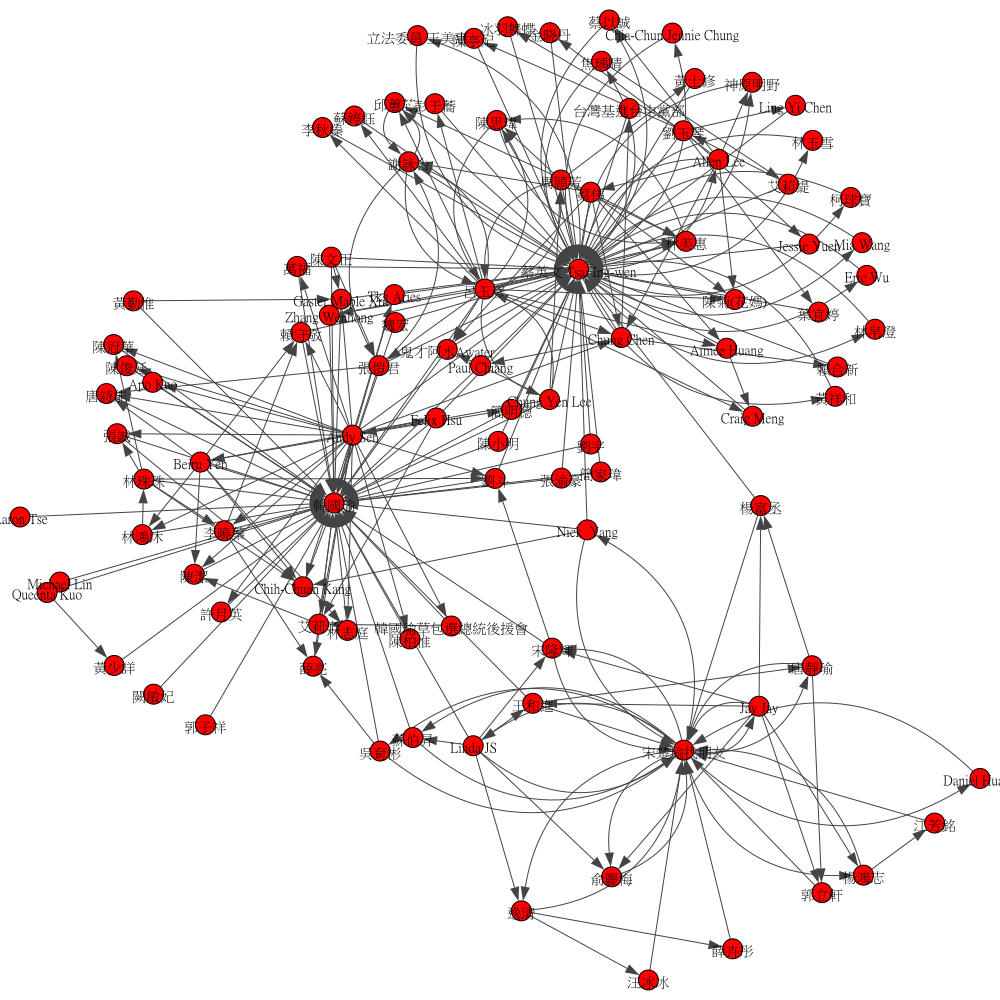

In [193]:
# kols = g.vs.select(pagerank_ge=0.000040)['name']
sg = g.subgraph(kols['name'])
layout = sg.layout("kk")
igraph.plot(sg, layout = layout,bbox=(0,0,1000,1000))

## 視覺化
- 先呈現整體樣貌+分群，看一下候選人的身邊的KOL數量，也進一步引出在身邊不一定就是支持，ex.草包選XXX

# ------------- NLP(4mins) -------------
- 處理的流程
> 斷詞 > tfidf > topicmodel
- 非結構化資料轉結構化
    - tf-idf
- 有些是單純支持，但有些則在反串
- 說話的內容可以分成哪些主題
    - 主權/草包/加油/。。。
- 透過NLP的分析技術，可以幫助我們了解KOL討論的話題
- 可以標註一下不同KOL討論的話題差異
- 一句話在不同的時間、事件下會有截然不同的意思，要考量整體的環境
    - ex.「唯一支持韓國瑜」
- 把沒有文字的回覆、留言去除掉(只回貼圖的人)

## 讀取資料

In [194]:
os.listdir('data/Comments')
comments = pd.concat([pd.read_pickle('data/Comments/Comments_201912.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Comments/Comments_202001.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Replies/Replies201912.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Replies/Replies202001.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']]],
                    ignore_index=True)
comments = comments.loc[comments['TIME'].between('2019-12-11','2020-01-10',True),:]

# 只保留 KOL 的說話內容
comments = pd.merge(left = comments,
                    right = kols.loc[:,['name']],
                    how = 'left',
                    left_on='AUTHOR',
                    right_on='name',
                    indicator=True)
comments = comments.loc[comments['_merge']=='both',['NAME','AUTHOR','TIME','TEXT']]
print(comments.shape)
comments.head()

(11502, 4)


,NAME,AUTHOR,TIME,TEXT
490,宋隆輝,1290743870,2019-12-24 11:14,站出來捍衛中華民國吧！ 2\n\nhttps://m.youtube.com/watch?f...
515,宋隆輝,1290743870,2019-12-14 22:51,痛罵他\nhttps://udn.com/news/story/7548/4226833?f...
522,宋隆輝,1290743870,2019-12-27 13:45,回來了，回來了\n全民最大黨討厭民進黨回來了\n\nhttps://tw.news.yaho...
525,宋隆輝,1290743870,2019-12-17 15:55,柯P語錄\nhttps://news.tvbs.com.tw/politics/124956...
550,宋隆輝,1290743870,2019-12-25 11:45,老趙看選到底\nhttps://tw.mobi.yahoo.com/news/%E9%83%...


In [195]:
comments = comments.groupby(['AUTHOR','NAME'])['TEXT'].apply(lambda x: ' '.join(x)).reset_index()
comments.head(5)

,AUTHOR,NAME,TEXT
0,100000035987513,林志庭,是同一批沒錯，才800萬人 網路竟然還很順 雨好像小了很多 燈海 正面的力量 市長加油。消滅...
1,100000077333366,陳俊廷,支持！否則只要民進黨繼續執政，此法以後是不是所有在對岸發展的藝人以及公眾人物都不得不站在民進...
2,100000106545512,陳冠華,烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑...
3,100000113417933,賴合新,好自信的蔡同學，電視辯論會只敢簽三立而不敢面對公視、中天、TVBS。看來三立的讀稿機還是比較...
4,100000126832450,郭子祥,選你出來當市長 你只顧著養雞蛋？ 不是老店一間接著一間倒嗎 張騰輝 帥吧🙋‍♂️🙋‍♂️🙋‍♂️


## 前處理
- 去除 emuji 、特殊符號
- 簡體轉繁體
- tfidf矩陣

### 僅保留中文

In [196]:
# 將非中文的文字、符號替換成空白
comments['TEXT2'] = comments['TEXT'].apply(lambda x: ''.join(re.sub('[^\u4e00-\u9fa5]', ' ', x))) 
comments['TEXT2'] = comments['TEXT2'].apply(lambda x: re.sub('[ ]{1,}', ' ', x))
comments = comments.loc[comments['TEXT2']!='',:]
# comments#.head(50)

### 斷詞

In [197]:
news = pd.read_csv('keywordsfromnews.csv')
keywords = []
for i in news['KEYWORDS']:
    try:
        keywords += i.split(',', -1)
    except:
        pass

words = ['即將', '辣台派','英眼部隊','小英','拜託','參加','最後','滷肉販', '好朋友','國政','臺灣','樸實無華','副總統','官職','大地震','難聽','賺錢','不知道','扭轉','韓總','一聲令下','使命必達', '藍軍','全壘打',
        '您們','民主退步黨','為國為民','壹週刊','抹紅','民主退步','長相','假掰','先贏再說','韓市長','子虛烏有','愛情摩天輪','彷彿','第十五屆','假民調','機構','說三道四','多說無益','幹你娘', '雞掰','不要臉','乞丐趕廟公',
        '慈善家','苦民所苦','惹毛','在野黨','走私菸','黑韓','流程','正副總統','沒人性','癥結','候選人','產業鏈', '舔共','蔡總統','韓國輸','模稜兩可','政府','憑什麼','憑甚麼','公部門','不懂','白賊義',
        '民進黨','國民黨','台獨','一國兩制','獨立','宋省長','宋先生','沒錯','網路']

keywords = list(set(keywords+words))
len(keywords)

14556

In [198]:
for i in keywords:
    jieba.add_word(i)
print('Complete!')

Complete!


In [199]:
# Stop words
stopwords = ['哈哈', '我們', '小姐', '謝謝', '就是', '可以', '大家', '分享', '很多', '同一', '沒錯', '竟然', '好像','否則','只要', '人物','幫忙','什麼',
             '一定', '沒有', '不要', '真的', '一起', '朋友', '加入', '直播', '票投', '為了', '檳榔', '這麼多', '晚安', '你們', '自己', '因為', '為何', '最後', '知道', '這樣', '一樣',
             '阿姨', '不會', '所以', '怎麼', '還是', '這麼', '早安', '一直', '呵呵', '人數', '這邊', '問題', '需要', '如果', '您們', '好好', '這是', '今天', '只有','多少',
             '為什麼', '一下', '開始', '趕快', '他們', '必須','但是', '小時', '雖然', '覺得', '起來', '會去', '感謝', '時候', '那邊','有沒有','比較',
             '哪裡', '等等', '這一', '棒棒', '不用', '目前', '怎樣', '鍵盤']

In [200]:
def sent2words(sent):
    words = []
    for i in jieba.lcut(sent):
        if i != ' ':
            if len(i) >= 2:
                if i not in stopwords:
                    words.append(i)
#     words = ' '.join(words)
    return  words

In [201]:
comments['TEXT3'] = comments['TEXT2'].apply(lambda x: sent2words(x))
comments['LENG'] = comments['TEXT3'].apply(lambda x: len(x))
# 去除詞太少的人
comments = comments.loc[comments['LENG'] >= 5,:]
comments['TEXT3'] = comments['TEXT3'].apply(lambda x: ' '.join(x))

print(comments.shape)
comments.head(2)

(93, 6)


,AUTHOR,NAME,TEXT,TEXT2,TEXT3,LENG
0,100000035987513,林志庭,是同一批沒錯，才800萬人 網路竟然還很順 雨好像小了很多 燈海 正面的力量 市長加油。消滅...,是同一批沒錯 才 萬人 網路竟然還很順 雨好像小了很多 燈海 正面的力量 市長加油 消滅網軍...,萬人 網路 燈海 正面 力量 市長 加油 消滅 網軍 霸凌 中華民國 友善 環境 滿滿 民心...,70
1,100000077333366,陳俊廷,支持！否則只要民進黨繼續執政，此法以後是不是所有在對岸發展的藝人以及公眾人物都不得不站在民進...,支持 否則只要民進黨繼續執政 此法以後是不是所有在對岸發展的藝人以及公眾人物都不得不站在民進...,支持 民進黨 繼續 執政 此法 以後 所有 對岸 發展 藝人 以及 公眾 不得不 民進黨 這...,87


In [202]:
# for i, j in zip(comments['TEXT2'],comments['TEXT3']):
#     print(i)
#     print('------')
#     print(j)
#     print('======')

### tf-idf 矩陣

In [203]:
vectorizer = TfidfVectorizer(analyzer='word',       
#                              max_df=0.95,
                             min_df=5,                        # minimum reqd occurences of a word 
                             # max_features=50000,             # max number of uniq words
                            )


# vectorizer = CountVectorizer(analyzer='word',       
# #                              max_df=0.95,
#                              min_df=5,                        # minimum reqd occurences of a word 
#                              lowercase=True# ,                   # convert all words to lowercase
#                             )

data_vectorized = vectorizer.fit_transform(comments['TEXT3'])
data_vectorized

<93x1052 sparse matrix of type '<class 'numpy.float64'>'
	with 9915 stored elements in Compressed Sparse Row format>

## LDA分析

In [204]:
n_components = 10

In [205]:
%%time
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=n_components,           # Number of topics
                                      max_iter=2000,              # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 3,               
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
# print(lda_model)  # Model attributes

Wall time: 38.7 s


In [206]:
# Create Document - Topic Matrix
# lda_output = best_lda_model.transform(data_vectorized)

# n_components = best_lda_model.n_components

# column names
topicnames = ["Topic" + str(i) for i in range(n_components)]

# index names
docnames = comments['AUTHOR']

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# # Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
AUTHOR,,,,,,,,,,,
100000035987513,0.020000,0.020000,0.020000,0.020000,0.470000,0.020000,0.020000,0.400000,0.020000,0.020000,4
100000077333366,0.020000,0.020000,0.020000,0.020000,0.070000,0.020000,0.020000,0.800000,0.020000,0.020000,7
100000106545512,0.030000,0.030000,0.030000,0.030000,0.090000,0.030000,0.030000,0.710000,0.030000,0.030000,7
100000113417933,0.020000,0.020000,0.020000,0.390000,0.020000,0.020000,0.020000,0.460000,0.020000,0.020000,7
100000126832450,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.630000,0.040000,0.040000,7
100000132063219,0.010000,0.010000,0.010000,0.010000,0.440000,0.010000,0.010000,0.480000,0.010000,0.010000,7
100000139515963,0.010000,0.010000,0.010000,0.010000,0.130000,0.010000,0.010000,0.770000,0.010000,0.010000,7
100000143531435,0.010000,0.010000,0.010000,0.010000,0.160000,0.010000,0.010000,0.770000,0.010000,0.010000,7
100000175122006,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,0.030000,0.030000,7


In [207]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,烙跑,便當,過來,老人,帳號,下去,韓國,市長,機會,大仁哥
Topic 1,機會,大仁哥,優秀,意外,信心,數字,今年,臺灣,韓國,蔡總統
Topic 2,垃圾,勝利,台妹,保台,嘉義,抗中,認真,全國,全都,今年
Topic 3,讀稿機,三立,空心菜,彼此,電視,面對,祝福,自信,全民,讀書
Topic 4,中共,香港,民主,共產黨,噩耗,祝福,好了,難民法,那就,成功
Topic 5,花蓮,回去,全民,嘉義,自稱,素養,參選,可憐,如何,能力
Topic 6,台南,賴清德,羨慕,造勢,至少,昨天,小英,機會,大仁哥,優秀
Topic 7,台灣,總統,支持,韓國瑜,加油,投票,高雄,小英,蔡英文,唯一
Topic 8,臺灣,肯定,英文,很難,不錯,早上,媽媽,要選,省長,人生
Topic 9,勢力,推動,打壓,或者,光明,至今,正面,伯伯,提出,意見


In [208]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,78
1,4,8
2,8,2
3,2,2
4,9,1
5,6,1
6,0,1


In [29]:
# 到底小英的高票是因為支持還是因為不喜歡韓??


- Topic0：支持蔡連任
- Topic1：博士學位議題
- Topic2：草包~
- Topic3：國家主權議題
- Topic4：宋楚瑜
- Topic5：支持韓

## 視覺化
- LDA VIS

In [73]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  29.465816
8       0.648955  71.707100       2        1  15.555300
9      71.019684   9.971006       3        1  11.903919
6       3.785981  33.185135       4        1   9.465174
2     -42.666500  -9.222070       5        1   8.963262
1      -3.621689 -43.526516       6        1   6.533108
0      -3.632402  -4.171708       7        1   5.385885
7     -36.584400  35.804413       8        1   4.549938
4      44.391380  50.615383       9        1   4.336900
5      40.235809 -31.591665      10        1   3.840700, topic_info=      Term         Freq        Total Category  logprob  loglift
536    民進黨  1968.000000  1968.000000  Default  30.0000  30.0000
721     臺灣  1148.000000  1148.000000  Default  29.0000  29.0000
891    韓國瑜  2255.000000  2255.000000  Default  28.0000  28.0000
162     加油  1197.000000  1197.000000  Default  27.0000  27.0000
549     法案   619.000000   619.000000  Default  26.0000  26.0000
205     台灣  2940.000000  2940.000000  Default  25.0000  25.0000
439     支持  1536.000000  1536.000000  Default  24.0000  24.0000
325     小英   807.000000   807.000000  Default  23.0000  23.0000
912     高雄   737.000000   737.000000  Default  22.0000  22.0000
336     市長   529.000000   529.000000  Default  21.0000  21.0000
530     民主   777.000000   777.000000  Default  20.0000  20.0000
680     總統  1809.000000  1809.000000  Default  19.0000  19.0000
649     立委   491.000000   491.000000  Default  18.0000  18.0000
894     韓粉   435.000000   435.000000  Default  17.0000  17.0000
271     大家   774.000000   774.000000  Default  16.0000  16.0000
219     哈哈   317.000000   317.000000  Default  15.0000  15.0000
303     守護   397.000000   397.000000  Default  14.0000  14.0000
69      人民   873.000000   873.000000  Default  13.0000  13.0000
402     我們  1063.000000  1063.000000  Default  12.0000  12.0000
223     唯一   549.000000   549.000000  Default  11.0000  11.0000
45      中國   674.000000   674.000000  Default  10.0000  10.0000
733    蔡英文   786.000000   786.000000  Default   9.0000   9.0000
821     通過   346.000000   346.000000  Default   8.0000   8.0000
726     草包   289.000000   289.000000  Default   7.0000   7.0000
688     美國   341.000000   341.000000  Default   6.0000   6.0000
682    總統府   349.000000   349.000000  Default   5.0000   5.0000
392     感動   230.000000   230.000000  Default   4.0000   4.0000
751     親中   210.000000   210.000000  Default   3.0000   3.0000
206    台灣人   497.000000   497.000000  Default   2.0000   2.0000
416     投票   497.000000   497.000000  Default   1.0000   1.0000
671     綠營    97.567140    98.453875   Topic1  -5.5863   1.2129
823     造勢    77.675748    78.562500   Topic1  -5.8143   1.2106
723     良心    61.762620    62.649399   Topic1  -6.0436   1.2077
874     陳菊    88.483335    90.495903   Topic1  -5.6841   1.1994
515     檢舉    36.898434    37.785180   Topic1  -6.5587   1.1982
317     對手    33.914711    34.801474   Topic1  -6.6430   1.1961
47      中天    26.952662    27.839492   Topic1  -6.8728   1.1896
379     惡意    25.958116    26.844923   Topic1  -6.9104   1.1883
597     生氣    24.963551    25.850354   Topic1  -6.9495   1.1870
840     選上    24.963529    25.850354   Topic1  -6.9495   1.1870
54      之後    52.721919    54.691482   Topic1  -6.2018   1.1853
516     檢討    22.974458    23.861217   Topic1  -7.0325   1.1841
286     女性    22.974430    23.861217   Topic1  -7.0325   1.1841
269     多數    22.974422    23.861217   Topic1  -7.0325   1.1841
349     幾乎    22.974393    23.861217   Topic1  -7.0325   1.1841
735     藍營    77.527554    80.548942   Topic1  -5.8162   1.1837
876     集中    21.979845    22.866648   Topic1  -7.0767   1.1824
165     動員    20.985274    21.872079   Topic1  -7.1231   1.1805
836     道理    19.990721    20.877511   Topic1  -7.1716   1.1785
217     呵呵    65.571824    68.600326   Topic1  -5.9837   1.1768
600     留下    18.9961

# ------------- SNA + NLP -------------
- 結合SNA與NLP的成果，我們發現各各社群討論的話題有明顯的差異
- 用 沉浸式簡報的方式，簡單回顧一下KOL們說了些什麼

- NLP與位在網絡核心也會有關係!
- KOL -> Key Opinion Consumer

----
- 韓國瑜陣營能夠製造話題，吸引大家來留言
- 📌但是其中不乏反對他的人
----
- 應用：

    

# ------------- SNA的動態觀察 -------------
- 有時間在做!
- [用python分析《三国演义》中的社交网络.ipynb](https://github.com/blmoistawinde/hello_world/blob/master/sanguo_network/用python分析《三国演义》中的社交网络.ipynb)

# ------------- 結語 -------------

- 透過SNA可以找到哪些人位在網絡的核心位置，接著可以透過NLP了解民眾的想法
- KOL 反映了民眾的想法，希望不同陣營的候選人可以針對這些議題正面回應!

- 政治獻金再也不用兩邊押寶(誤
- 不同產業/領域的關聯資料的意義有很大的差異，也不會每個鏈接都有意義。分析者在分析時還是需要結合Domain Knowkedge進行解析
    - 社群： 找出 KOL 幫助行銷
    >  找出 KOL 與KOL的興趣/偏好，避免KOL流失 (做出幾個標籤，怎麼做，怎麼貼)
    - 人資:  離職風險偵測
    - 電信:  流失風險偵測(人)
    - 金融:  偵測異常金流
    - 客服： 服務流程設計(服務流程), 服務間的關聯，設計最適的服務流程
    - 最後一個留給大家想，如果有任何的討論/建議我都會非常感謝!
> 不管你的身份是想要找到KOL幫你轉播訊息，或者你是分析師想要找到KOL，或者是一般民眾想要識別出真/假的KOL，都希望你會在這場演講中有收穫
> 資料會釋出，有興趣的人可以到以下網址尋找


# QA時間(5分)

# ------------- 潛在提問 -------------
- 網軍議題
> 其實在投稿的時候只是想要認真的用資料聊八卦，結果6月的時候就被罷免，讓這個議題突然變得很敏感。不過就像在前面提到的透過節點重要性的方式可以幫助我們區辨出真正的KOL和網軍。
- 要怎麼選擇filter的critical value
> 這個需要評估你有多少的資源，除了人力，還有你的時間，時間多的話就可以看得多一些。相反的話則看前面就好。畢竟不會每個關聯都很重要。。例如對於金融業在抓異常金流的時候，如果金流只有50/100，顯然就不是這麼重要.

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3       1.465019 -47.625065       1        1  33.488724
2      54.854797 -36.476795       2        1  24.783255
5      32.212929 -61.444572       3        1  16.474535
1       5.111096 -14.110332       4        1  11.705751
0      26.350170 -33.374702       5        1   9.465678
4      38.109818  -7.222781       6        1   4.082057, topic_info=      Term          Freq         Total Category  logprob  loglift
2900   韓國瑜  33702.000000  33702.000000  Default  30.0000  30.0000
1476    支持  27205.000000  27205.000000  Default  29.0000  29.0000
769     唯一  16883.000000  16883.000000  Default  28.0000  28.0000
1776   民進黨  12877.000000  12877.000000  Default  27.0000  27.0000
572     加油  17574.000000  17574.000000  Default  26.0000  26.0000
2375   蔡英文  13500.000000  13500.000000  Default  25.0000  25.0000
701     台灣  25627.000000  25627.000000  Default  24.0000  24.0000
2227    總統  23530.000000  23530.000000  Default  23.0000  23.0000
1096    小英   6108.000000   6108.000000  Default  22.0000  22.0000
1024   宋楚瑜   3182.000000   3182.000000  Default  21.0000  21.0000
1191   張善政   4970.000000   4970.000000  Default  20.0000  20.0000
611     博士   3108.000000   3108.000000  Default  19.0000  19.0000
823     國政   3670.000000   3670.000000  Default  18.0000  18.0000
2130    立委   4855.000000   4855.000000  Default  17.0000  17.0000
1400    投票   3272.000000   3272.000000  Default  16.0000  16.0000
1763    民主   4400.000000   4400.000000  Default  15.0000  15.0000
2751    還是   3528.000000   3528.000000  Default  14.0000  14.0000
2908    韓粉   4196.000000   4196.000000  Default  13.0000  13.0000
40      一樣   2938.000000   2938.000000  Default  12.0000  12.0000
865     堅定   2735.000000   2735.000000  Default  11.0000  11.0000
2689    連任   2368.000000   2368.000000  Default  10.0000  10.0000
199   中華民國   6534.000000   6534.000000  Default   9.0000   9.0000
2327    臺灣   2419.000000   2419.000000  Default   8.0000   8.0000
137     不會   4579.000000   4579.000000  Default   7.0000   7.0000
1811    法案   1327.000000   1327.000000  Default   6.0000   6.0000
2220    網軍   3974.000000   3974.000000  Default   5.0000   5.0000
553    副總統   2520.000000   2520.000000  Default   4.0000   4.0000
2753    還有   3441.000000   3441.000000  Default   3.0000   3.0000
2354    草包   3642.000000   3642.000000  Default   2.0000   2.0000
1930   王小姐   2276.000000   2276.000000  Default   1.0000   1.0000
703    台灣國    789.127818    789.960635   Topic1  -6.3158   1.0929
2952    马洪    587.389818    588.225601   Topic1  -6.6110   1.0925
1681   柯文哲    544.448646    545.282011   Topic1  -6.6870   1.0924
2214    網友    483.529130    484.362029   Topic1  -6.8056   1.0922
627     原因    311.751678    312.587642   Topic1  -7.2445   1.0913
922     大港    293.777107    294.611260   Topic1  -7.3039   1.0911
341     你贏    276.800076    277.633560   Topic1  -7.3634   1.0910
2448    觀看    259.819515    260.655855   Topic1  -7.4267   1.0907
2383    藝人    242.843971    243.678157   Topic1  -7.4943   1.0905
695    台北市    239.847998    240.682092   Topic1  -7.5067   1.0905
555     創新    195.901850    196.739800   Topic1  -7.7091   1.0897
1912    爭議    183.921104    184.755547   Topic1  -7.7722   1.0894
1200    強調    178.927996    179.762108   Topic1  -7.7998   1.0893
2457    計畫    178.923690    179.762099   Topic1  -7.7998   1.0893
354     來自    177.928050    178.763419   Topic1  -7.8054   1.0893
1593    暴徒    177.927228    178.763418   Topic1  -7.8054   1.0893
2646    退休    171.936112    172.771289   Topic1  -7.8396   1.0891
2773    邱毅    170.937579    171.772602   Topic1  -7.8454   1.0891
2135    站台    169.938843    170.773913   Topic1  -7.8513   1.0891
408     債務    166.944815    167.777851   Topic1  -7.8691   1.0890
1707    極權    166.940645    167.777844   Topic1  -7.8691   1.0890
919     大會    156.954632    157.790964   Topic1  -7.9308   1.0886
351     來台 

# 交叉分析
- 組合SNA與LDA的分析結果

In [110]:
df_document_topic.reset_index()

,AUTHOR,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
0,46251501064,0.39,0.00,0.08,0.53,0.00,0.00,3
1,1863023523934803,0.00,0.00,0.50,0.00,0.00,0.49,2
2,100009264227130,0.08,0.07,0.18,0.36,0.00,0.30,3
3,100000364294377,0.05,0.00,0.26,0.65,0.03,0.02,3
4,100005413301437,0.20,0.03,0.41,0.30,0.02,0.04,2
...,...,...,...,...,...,...,...,...
1074,100008169678237,0.00,0.30,0.42,0.19,0.00,0.08,2
1075,100004438576931,0.01,0.14,0.36,0.43,0.01,0.05,3
1076,100042475011195,0.00,0.00,0.99,0.01,0.00,0.00,2
1077,1376293908,0.00,0.04,0.60,0.34,0.02,0.00,2


In [111]:
KOLS.loc[:,['AUTHOR','NAME','Weighted Degree','modularity_class','TEXT','TEXT3']]

,AUTHOR,NAME,Weighted Degree,modularity_class,TEXT,TEXT3
0,46251501064,蔡英文 Tsai Ing-wen,449403,0,大支表演中，總統也即將到場！ 高雄辣台派都到現場了嗎？記得傳line告訴我你在現場！ htt...,大支 表演 中 總統 也 即將 到場 高雄 辣台派 都 到 現場 了 嗎 記得 傳 告訴 我...
1,1863023523934803,韓國瑜,557902,1,大家明天見！\n沒有養寵物也可以一起來拍照做愛心 🥰 大家明天見！\n沒有養寵物也可以一起來...,大家 明天 見 沒有 養 寵物 也 可以 一 起來 拍照 做 愛心 大家 明天 見 沒有 養...
2,100009264227130,張榮發,454,3,在等一位全民總統倒數61天\n#國政領航經濟起飛臺灣💪\n赤子之心樸實無華性格感動\n唯一支...,在 等 一位 全民 總統 倒數 天 國政 領航 經濟 起飛 臺灣 赤子之心 樸實無華 性格 ...
3,100000364294377,陳一惇,144,3,加油加油💪 希望能有辛辣的問題，相信韓總更能發揮，讓誤會您的年輕朋友們眼睛一亮！\n絕對不要...,加油 加油 希望 能 有 辛辣 的 問題 相信 韓總 更能 發揮 讓 誤會 您 的 年輕 朋...
4,100005413301437,Wie Liao,550,4,唯一支持韓國輸 2020落選+罷免 韓國輸的可憐 韓國愉快不起來😫😫 1月你也會在輸一次的 ...,唯一 支持 韓國輸 落選 罷免 韓國輸 的 可憐 韓國 愉快 不 起來 月 你 也 會 在 ...
...,...,...,...,...,...,...
1074,100008169678237,黃玉鳳,111,3,CY Lin 你搞清楚 國小生老師 在課堂上教保險套的使用方法 家長出來陳情 堯轅 四年出來...,你 搞清楚 國 小生 老師 在 課堂 上教 保險套 的 使用 方法 家長 出來 陳 情 堯轅...
1075,100004438576931,黃秀芸,180,3,看到無言...快昏倒..最後笑翻\nhttps://youtu.be/pM3ja10...,看到 無言 快 昏倒 最後 笑 翻 看到 無言 快 昏倒 最後 笑 翻 好 星期一 就 去 ...
1076,100042475011195,黃黎華,271,3,趙羽翼 阿翼.我來助攻嘴綠綠! 梁國謙 黃中信 Phung J Zong 黃中信 黃中信 黃...,趙 羽翼 阿翼 我來 助攻 嘴 綠綠 梁國謙 黃 中信 黃 中信 黃 中信 黃 中信 黃 中...
1077,1376293908,龔文忠,161,4,"去X菊的FB講 拎刀系郎!? 真是萬民擁戴,我在郭,韓的FB看到不少不認同他們的留言,在這裡...",去 菊 的 講 拎 刀 系郎 真是 萬民 擁戴 我 在 郭 韓的 看到 不少 不 認同 他們...


In [112]:
KOLS2 = pd.merge(left=KOLS.loc[:,['AUTHOR','NAME','Weighted Degree','modularity_class','TEXT']],
                 right=df_document_topic.reset_index(),
                 how='left',
                 on='AUTHOR')
KOLS2.head(1000)

,AUTHOR,NAME,Weighted Degree,modularity_class,TEXT,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
0,46251501064,蔡英文 Tsai Ing-wen,449403,0,大支表演中，總統也即將到場！ 高雄辣台派都到現場了嗎？記得傳line告訴我你在現場！ htt...,0.39,0.00,0.08,0.53,0.00,0.00,3
1,1863023523934803,韓國瑜,557902,1,大家明天見！\n沒有養寵物也可以一起來拍照做愛心 🥰 大家明天見！\n沒有養寵物也可以一起來...,0.00,0.00,0.50,0.00,0.00,0.49,2
2,100009264227130,張榮發,454,3,在等一位全民總統倒數61天\n#國政領航經濟起飛臺灣💪\n赤子之心樸實無華性格感動\n唯一支...,0.08,0.07,0.18,0.36,0.00,0.30,3
3,100000364294377,陳一惇,144,3,加油加油💪 希望能有辛辣的問題，相信韓總更能發揮，讓誤會您的年輕朋友們眼睛一亮！\n絕對不要...,0.05,0.00,0.26,0.65,0.03,0.02,3
4,100005413301437,Wie Liao,550,4,唯一支持韓國輸 2020落選+罷免 韓國輸的可憐 韓國愉快不起來😫😫 1月你也會在輸一次的 ...,0.20,0.03,0.41,0.30,0.02,0.04,2
5,100000404266312,Felix Hsu,957,4,https://www.facebook.com/100000404266312/posts...,0.07,0.03,0.42,0.46,0.00,0.03,3
6,100004722182299,劉斗,11341,4,我真替 打虎英雄 前台北縣長 周先生 感到 氣憤，為了國瑜兄拼了那麼久了，結果副總統是別人，...,0.01,0.03,0.58,0.21,0.02,0.15,2
7,100037613541194,張愷君,701,4,從來沒看過這麼低俗的候選人，心裏一直想著潘金蓮， 難怪加分要出來說x交跟×...,0.06,0.00,0.69,0.25,0.00,0.00,2
8,100002448422154,簡明德,330,3,堅定不移 挺我兄弟🇹🇼 堅定不移 挺我兄弟 !! 堅定不移 挺我兄弟 !! 賴功德說：「最黑...,0.00,0.27,0.07,0.19,0.04,0.43,5
9,100000126832450,郭子祥,187,4,可能宿醉還沒退 因該差不多知道自己選不上 先找好台階讓自己下🥺🥺🥺 不是老店一間接著一間倒嗎...,0.02,0.02,0.92,0.02,0.02,0.02,2


In [114]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,台灣,小英,總統,加油,投票,臺灣,連任,蔡英文,民主,我們,大家,選票,一定,王小姐,香港,要贏,過半,支持,立委,呂玉彥
Topic 1,蔡英文,博士,民進黨,台灣,網軍,還有,政府,人民,沒有,民主,下台,論文,總統,可以,公投,什麼,土地,台灣人,自己,私菸
Topic 2,韓國瑜,自己,什麼,韓粉,草包,不要,你們,高雄,真的,市長,可以,沒有,不是,就是,支持,我們,總統,一個,不會,出來
Topic 3,台灣,國民黨,民進黨,總統,中國,就是,我們,中華民國,國家,韓國瑜,沒有,不是,你們,人民,什麼,中共,可以,一個,現在,自己
Topic 4,民進黨,宋楚瑜,法案,親民黨,藍綠,立委,一樣,還是,主席,機會,服務,不會,台灣,百姓,包含,條例,通過,現在,幫忙,不是
Topic 5,韓國瑜,支持,唯一,加油,總統,張善政,國政,台灣,中華民國,當選,下架,堅定,我們,庶民,副總統,人民,大家,市長,凍蒜,韓總


In [115]:
KOLS2.to_pickle(path+'InterActive/KOLS2_Ana.pickle')

In [116]:
import prince

In [124]:
caplot=KOLS2.groupby(['modularity_class','dominant_topic']).size().reset_index()
caplot.columns=['modularity_class','dominant_topic','Freq']
caplot = caplot.pivot_table(index='modularity_class',columns='dominant_topic',values='Freq',fill_value=0)
caplot

dominant_topic,0,1,2,3,4,5
modularity_class,,,,,,
0,78,20,40,114,3,10
1,19,1,164,74,1,244
2,4,1,5,14,6,0
3,2,2,71,36,0,36
4,1,3,104,20,0,2
5,0,0,6,0,0,0


In [127]:
ca = prince.CA(n_components=2,
               n_iter=3,
               copy=True,
               check_input=True,
               engine='auto',
               random_state=42)
caplot.columns.rename('dominant_topic', inplace=True)
caplot.index.rename('modularity_class', inplace=True)
ca = ca.fit(caplot)

C:\ProgramData\Anaconda3\lib\site-packages\prince\ca.py:99: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(X, pd.SparseDataFrame):
C:\ProgramData\Anaconda3\lib\site-packages\prince\ca.py:124: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(X, pd.SparseDataFrame):


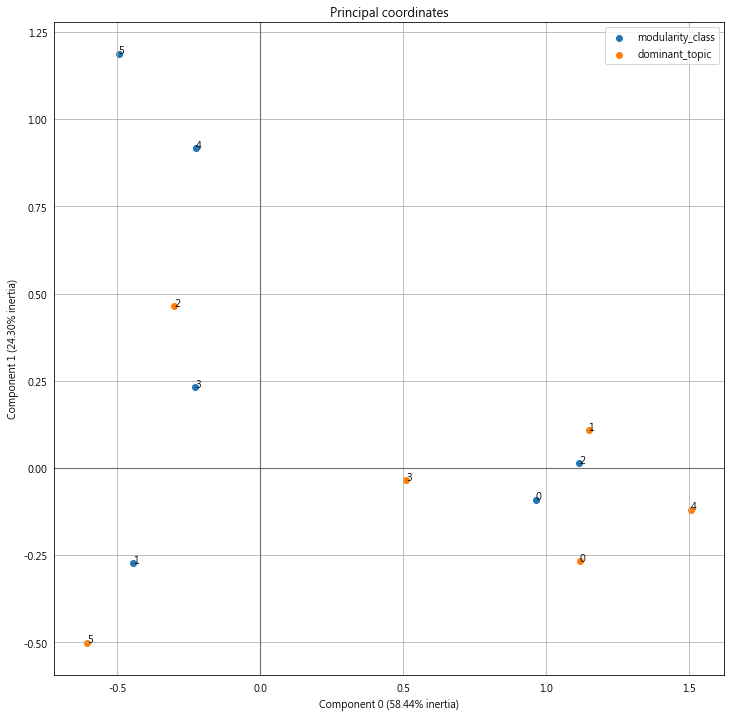

In [129]:
ax = ca.plot_coordinates(X=caplot,
                         ax=None,
                         figsize=(12, 12),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)
ax

- 社群
 - 0：單純蔡
 - 1：單純韓
 - 2：宋楚瑜
 - 3：韓的中介橋樑
 - 4：蔡粉絲跑去韓吵架

 - 5：??
- 議題
 - Topic0：支持蔡連任
 - Topic1：博士學位議題
 - Topic2：帶職參選、草包~
 - Topic3：國家主權議題
 - Topic4：宋楚瑜
 - Topic5：支持韓
 
 - 老跑、香港、被抹黑...

# 追蹤留言

In [22]:
stack.loc[stack['AUTHOR']=='1023721804',:]

,NAME,AUTHOR,TIME,TEXT,POSTID,COMMENTID,PageName
1110706,黃之鋒,1023721804,2019-11-01 20:06,香港的情況的確在倒退，台灣一定要加油！,781711005619916,150870206145287,蔡英文 Tsai Ing-wen
1404633,黃之鋒,1023721804,2020-01-13 08:23,感謝蔡總統，台灣香港一起加油！,10156368927336065,468216694087635,蔡英文 Tsai Ing-wen
4486772,黃之鋒,1023721804,2019-11-14 19:29,謝謝支持，希望香港有一天也能跟台灣一樣自己選自己的政府,2600966760140472,2600974820139666,韓國瑜
5568939,黃之鋒,1023721804,2019-11-14 19:55,還有拜托不要再進中聯辦了！,2600966760140472,2385051798380179,韓國瑜


In [10]:
stack.loc[stack['AUTHOR']=='100000164000781',:]

,NAME,AUTHOR,TIME,TEXT,POSTID,COMMENTID,PageName
1734823,Abby Lee,100000164000781,2020-01-08 12:22,臺灣加油！,1232583490263586,462680087737505,蔡英文 Tsai Ing-wen
2267110,Abby Lee,100000164000781,2019-06-13 23:09,淒慘,2461318357438647,130321064836073,韓國瑜
2421143,Abby Lee,100000164000781,2020-01-11 22:01,❤️,2698248050240567,222573275410662,蔡英文 Tsai Ing-wen
2421145,Abby Lee,100000164000781,2020-01-11 22:05,😢,2698248050240567,1280267035514841,蔡英文 Tsai Ing-wen
2434895,Abby Lee,100000164000781,2020-01-11 21:58,大家可以好好睡了,2698248050240567,597910514277015,蔡英文 Tsai Ing-wen
2437091,Abby Lee,100000164000781,2020-01-11 22:02,我們大家一起加油,2698248050240567,629999254479059,蔡英文 Tsai Ing-wen
2440098,Abby Lee,100000164000781,2020-01-11 22:09,好好讓聲帶休息了,2698248050240567,583781932414242,蔡英文 Tsai Ing-wen
2443972,Abby Lee,100000164000781,2020-01-11 21:57,大家辛苦了👍,2698248050240567,2485737768362074,蔡英文 Tsai Ing-wen
2446559,Abby Lee,100000164000781,2020-01-11 22:00,真的,2698248050240567,190700512116947,蔡英文 Tsai Ing-wen
2446562,Abby Lee,100000164000781,2020-01-11 21:58,真的,2698248050240567,560314131188059,蔡英文 Tsai Ing-wen


In [28]:
comments = pd.concat([pd.read_pickle('data/Comments/Comments_201912.pkl'),
                      pd.read_pickle('data/Comments/Comments_202001.pkl'),
                      pd.read_pickle('data/Replies/Replies201912.pkl'),
                      pd.read_pickle('data/Replies/Replies202001.pkl')],
                    ignore_index=True)
comments = comments.loc[comments['TIME'].between('2019-12-11','2020-01-10',True),:]

In [37]:
comments.loc[comments['AUTHOR']=='100004133415405',]
# 100006855841686
# 1452278128421385
# 1485217555
# 1608504506
# 1863023523934803
# 5402638
# 769328496
# 100004133415405

,NAME,AUTHOR,TIME,TEXT,REPLIES,LIKECOUNT,POSTID,COMMENTID,PARENTCOMMENTID
685068,林玉雪,100004133415405,2020-01-05 12:53,111一定會去投票,11,270,10156349212431065,10156349216621065,NaN
993211,林玉雪,100004133415405,2020-01-08 15:45,台灣加油！,0,0,1490096344483163,415484855842434,NaN
1172596,林玉雪,100004133415405,2020-01-09 14:28,加油！加油！加油！,0,0,577215709673725,577221069673189,NaN


# 其他

候選人的代表詞是什麼?
- 把貼文內容當做X，預測是韓/蔡還是宋的貼文，看關鍵字個別是什麼?

In [14]:
!pip install opencc-python

  Using cached opencc-python-0.1.zip (944 kB)


    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Miniconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\TL_Yu\\AppData\\Local\\Temp\\pip-install-kguffg1r\\opencc-python\\setup.py'"'"'; __file__='"'"'C:\\Users\\TL_Yu\\AppData\\Local\\Temp\\pip-install-kguffg1r\\opencc-python\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\TL_Yu\AppData\Local\Temp\pip-install-kguffg1r\opencc-python\pip-egg-info'
         cwd: C:\Users\TL_Yu\AppData\Local\Temp\pip-install-kguffg1r\opencc-python\
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\TL_Yu\AppData\Local\Temp\pip-install-kguffg1r\opencc-python\setup.py", line 1, in <module>
        from distribute_setup import use_setuptools
    ModuleNotFou

In [3]:
from opencc import OpenCC
cc = OpenCC('s2t')  # convert from Simplified Chinese to Traditional Chinese
# can also set conversion by calling set_conversion
# cc.set_conversion('s2tw')
to_convert = '开放中文转换'
cc.convert(to_convert)

OSError: [WinError 126] 找不到指定的模組。

In [13]:
# 讀取回覆資料
files = os.listdir('data/Replies')
Replies = []
for i in files:
    ndf = pd.read_pickle('data/Replies/'+ i)
    ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'PARENTCOMMENTID','TEXT']]
    gc.collect()
    print(i, ndf.shape)
    Replies.append(ndf)
Replies = pd.concat(Replies, ignore_index=True)
Replies.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'PARENTCOMMENTID','TEXT']
Replies['PARENTCOMMENTID'] = Replies['PARENTCOMMENTID'].apply(lambda x: x.split('_',-1)[-1])
Replies = Replies.drop_duplicates(keep='first')
print(Replies.shape)

Replies201901.pkl (60392, 5)
Replies201902.pkl (40896, 5)
Replies201903.pkl (62983, 5)
Replies201904.pkl (78545, 5)
Replies201905.pkl (94891, 5)
Replies201906.pkl (159674, 5)
Replies201907.pkl (83711, 5)
Replies201908.pkl (121623, 5)
Replies201909.pkl (100832, 5)
Replies201910.pkl (164424, 5)
Replies201911.pkl (166414, 5)
Replies201912.pkl (234096, 5)
Replies202001.pkl (211280, 5)
Replies202002.pkl (71839, 5)
Replies202003.pkl (75284, 5)
Replies202004.pkl (22647, 5)
(1690033, 5)


In [15]:
Replies.loc[Replies['SOURCE_NAME']=='蔡英文 Tsai Ing-wen',:] 

,SOURCE_NAME,SOURCE,TIME,PARENTCOMMENTID,TEXT
16585,蔡英文 Tsai Ing-wen,46251501064,2019-01-03 11:44,10155579287736065,謝謝！一起為台灣努力！
16931,蔡英文 Tsai Ing-wen,46251501064,2019-01-03 11:05,10155579294286065,加油，一起努力！
17211,蔡英文 Tsai Ing-wen,46251501064,2019-01-03 11:18,10155579303696065,一起加油喔！
17655,蔡英文 Tsai Ing-wen,46251501064,2019-01-03 11:27,10155579314221065,👍👍👍
18628,蔡英文 Tsai Ing-wen,46251501064,2019-01-03 13:38,324718184835145,一起加油！
18775,蔡英文 Tsai Ing-wen,46251501064,2019-01-03 13:39,363292814500485,一起加油！
22592,蔡英文 Tsai Ing-wen,46251501064,2019-01-04 17:53,10155581303201065,謝謝，一起守護台灣豬豬！
22872,蔡英文 Tsai Ing-wen,46251501064,2019-01-04 17:55,10155581304571065,一起加油喔！
38405,蔡英文 Tsai Ing-wen,46251501064,2019-01-14 20:54,10155599457501065,多一份「雞婆精神」，就多一個孩子可以得到幫助。一起幫忙分享這則訊息給朋友吧！
43814,蔡英文 Tsai Ing-wen,46251501064,2019-01-21 12:35,10155610427076065,謝謝，一起加油，當 #辣台派 ！
